## 載入套件

In [7]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

## 設定超參數

In [8]:
epochs = 5
num_classes = 11 # 分類的類別數量，包括手寫數字 0 到 9 以及一個空白標籤。
blank_label = 10 # 代表空白的標籤，用於序列中不包含手寫數字的位置。
image_height = 28
gru_hidden_size = 128 # GRU（Gated Recurrent Unit）的隱藏層維度，即記憶體單元的大小。
gru_num_layers = 2 # GRU 的層數，用於指定 GRU 模型的深度。
cnn_output_height = 4 # 卷積神經網絡（CNN）輸出特徵圖的高度（以像素為單位）。
cnn_output_width = 32 # 卷積神經網絡（CNN）輸出特徵圖的寬度（以像素為單位）。
digits_per_sequence = 5 # 每個序列中包含的手寫數字數量。
number_of_sequences = 10000 # 要生成的手寫數字序列的總數量。


## 產生手寫OCR 資料集

In [9]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import numpy as np

# 創建 EMNIST 資料集物件，專注於手寫數字字符
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)

# 初始化空列表，用於儲存序列圖像和標籤
dataset_sequences = []
dataset_labels = []

# 迴圈用於生成指定數量的序列
for i in range(number_of_sequences):
    # 從 EMNIST 資料集中隨機選擇索引
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    # 迴圈對每個隨機選擇的數字圖像進行轉換
    for img in random_digits_images:
        # 將張量圖像轉換為 PIL 圖像
        img = transforms.ToPILImage()(img)
        # 將圖像逆時針旋轉 -90 度，並以填充值 0 進行填充
        img = TF.rotate(img, -90, fill=0)
        # 水平翻轉圖像
        img = TF.hflip(img)
        # 使用隨機仿射變換（旋轉、平移、縮放）
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        # 將轉換後的 PIL 圖像轉換回張量，然後再轉換為 NumPy 數組
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    # 將轉換後的圖像列表轉換為 NumPy 數組
    random_digits_images = np.array(transformed_random_digits_images)
    # 獲取隨機選擇的數字圖像的標籤
    random_digits_labels = emnist_dataset.targets[random_indices]
    # 將數字圖像序列和標籤進行重塑
    random_sequence = np.hstack(random_digits_images.reshape(digits_per_sequence, 28, 28))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    # 正規化序列圖像的像素值，並將其儲存到資料集列表中
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)


100.0%


Extracting ./EMNIST\EMNIST\raw\gzip.zip to ./EMNIST\EMNIST\raw


## 訓練與測試資料集

In [10]:
dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

## CRNN

![連結文字](https://ycc.idv.tw/media/CV/crnn_structure.png)

In [12]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()

        # 卷積層1，輸入通道數 1，輸出通道數 32，卷積核大小 (3, 3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)  # 正規化層
        # 卷積層2，輸入通道數 32，輸出通道數 32，卷積核大小 (3, 3)，步長 2
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        # 卷積層3，輸入通道數 32，輸出通道數 64，卷積核大小 (3, 3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        # 卷積層4，輸入通道數 64，輸出通道數 64，卷積核大小 (3, 3)，步長 2
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)

        # 計算 GRU 輸入尺寸，即卷積輸出的高度 * 64
        self.gru_input_size = cnn_output_height * 64

        # 雙向 GRU，輸入尺寸、隱藏層維度、層數、batch_first=True、bidirectional:在做雙向GRU
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)

        # 全連接層，將 GRU 輸出映射到類別數量
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        # 通過卷積層1，正規化，並應用 leaky ReLU 激活函數
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)

        # 通過卷積層2，正規化，並應用 leaky ReLU 激活函數
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)

        # 通過卷積層3，正規化，並應用 leaky ReLU 激活函數
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)

        # 通過卷積層4，正規化，並應用 leaky ReLU 激活函數
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)

        # 重新排列維度以適合 GRU 輸入
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)

        # 通過雙向 GRU 層
        out, _ = self.gru(out)

        # 通過全連接層，並應用對數 softmax 函數
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

# 創建 CRNN 模型實例
model = CRNN()

# 設定連接時間序列的CTC損失函數
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### 名詞解釋：

**- Instance Normalization**

Instance Normalization 中，對於每個輸入實例，它會計算出該實例在每個通道上的平均值和標準差，然後對該實例的每個通道進行獨立的正規化，使其均值為0，標準差為1。這樣的操作可以幫助控制梯度的傳播，並提供穩定的輸入分佈，從而促使模型更好地學習

**- CTCLoss**

CTCLoss 中，有一個特殊的 "空白" 標籤，它表示序列中的間隔。模型可以在預測序列中插入多個空白標籤，以適應預測和目標序列之間的長度不匹配。CTCLoss 通過計算不同的對齊方式下的概率和，然後找到最可能的對齊方式，從而計算模型預測和目標之間的差異。

![ctcloss](https://ycc.idv.tw/media/CV/ctc_mapping.png)

**- Leaky ReLU（Leaky Rectified Linear Unit）**

公式定義如下：

f(x) =
{
x, x > 0
αx, x ≤ 0
}

其中 x 是輸入，α 是一個小的正常數（例如0.01），它的主要作用是當 x 小於或等於 0 時，還能讓神經元有一個小的梯度，避免神經元完全不活躍。解決了 ReLU 函數在 x < 0 時梯度消失的問題，這有助於深度神經網絡中的反向傳播和參數更新。

## 訓練模型

In [13]:
for _ in range(epochs):

    train_correct = 0  # 正確預測
    train_total = 0  # 總樣本

    for x_train, y_train in train_loader:

        batch_size = x_train.shape[0]  # 當前批次大小，即樣本數
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])  # 調整輸入的維度

        optimizer.zero_grad()  # 清零梯度
        y_pred = model(x_train)  # 使用模型進行預測
        y_pred = y_pred.permute(1, 0, 2)  # 改變預測張量的維度，原本維度為(批次大小, 序列長度, 類別數量)，改變成(序列長度, 批次大小, 類別數量)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)  # 填充輸入序列的長度
        target_lengths = torch.IntTensor([len(t) for t in y_train])  # 計算每個目標序列的長度

        loss = criterion(y_pred, y_train, input_lengths, target_lengths)  # 計算損失
        loss.backward()  # 反向傳播計算梯度
        optimizer.step()  # 優化器更新參數

        _, max_index = torch.max(y_pred, dim=2)  # 取最大值
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # 轉換預測索引為 NumPy 陣列
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])  # 去除空白標籤
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                # 如果預測和實際目標序列相同，則計數器增加
                train_correct += 1
            train_total += 1

    # 輸出訓練結果
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)


TRAINING. Correct:  50 / 8000 = 0.00625
TRAINING. Correct:  4919 / 8000 = 0.614875
TRAINING. Correct:  6681 / 8000 = 0.835125
TRAINING. Correct:  7091 / 8000 = 0.886375
TRAINING. Correct:  7301 / 8000 = 0.912625


## 測試模型

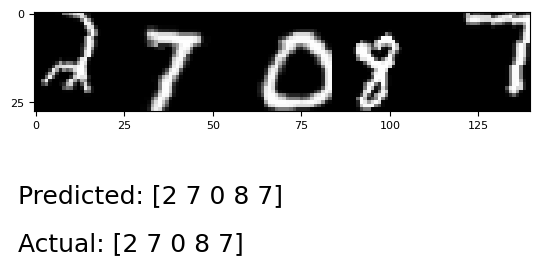

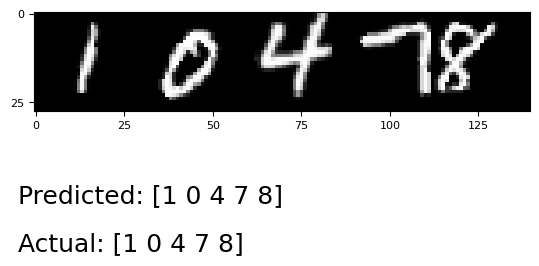

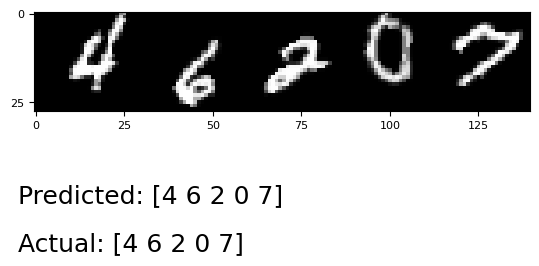

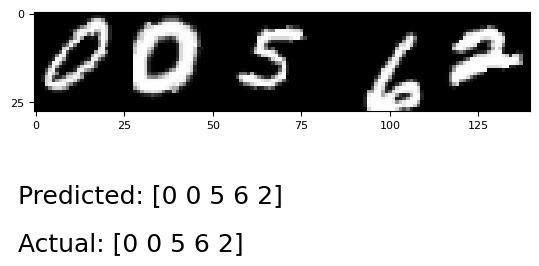

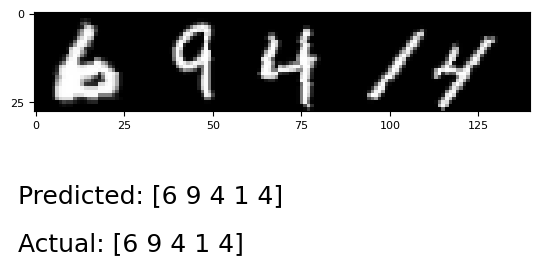

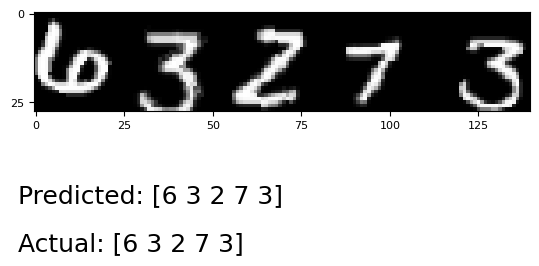

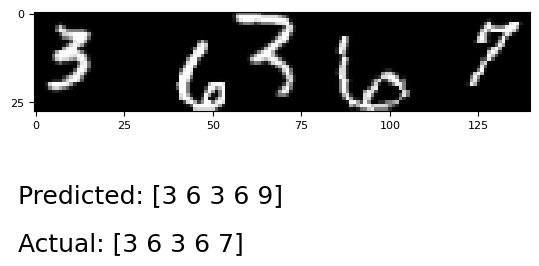

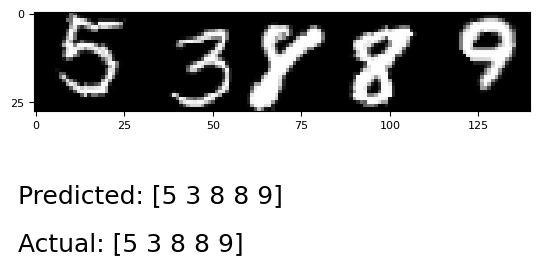

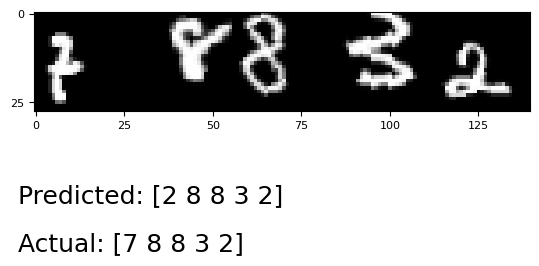

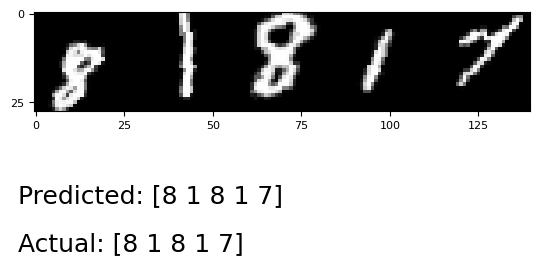

In [14]:
number_of_test_imgs = 10  # 指定測試集中的圖像數量
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)  # 使用測試集創建數據載入器
test_preds = []  # 儲存測試的預測結果

# 獲取下一批測試數據
(x_test, y_test) = next(iter(test_loader))

# 通過模型進行預測
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)  # 重新排列預測張量的維度
_, max_index = torch.max(y_pred, dim=2)

# 對每個測試樣本進行預測結果處理
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # 將預測的索引轉換為 NumPy 陣列
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])  # 去除空白標籤
    test_preds.append(prediction)  # 儲存預測結果

# 顯示測試結果
for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8  # 設置字體大小
    plt.imshow(x_test[j], cmap='gray')  # 顯示測試圖像
    mpl.rcParams["font.size"] = 18  # 恢復字體大小
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))  # 顯示實際標籤
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))  # 顯示預測標籤
    plt.show()  # 顯示圖像及標籤信息
